# 🧠 Qwen2.5 Brain MRI Disease Diagnosis

Predict disease based on clinical history and image findings using Qwen2.5.

## 1. Setup & Imports

In [1]:
import os, json, base64, sys
from openai import OpenAI
from dotenv import load_dotenv
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

def encode_image_to_data_uri(path: str) -> str:
    with open(path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode('utf-8')
    return f"data:image/png;base64,{b64}"

DATASET_DIR = "VLM-Seminar25-Dataset/nova_brain"
IMAGES_DIR = os.path.join(DATASET_DIR, "images")
ANNOT_PATH = os.path.join(DATASET_DIR, "annotations.json")
RESULTS_DIR = "../results/nova_brain/diagnosis"
os.makedirs(RESULTS_DIR, exist_ok=True)

with open(ANNOT_PATH, "r") as f:
    annotations = json.load(f)
case_ids = list(annotations.keys())

load_dotenv(dotenv_path="../config/user.env")
api_key = os.environ.get("NEBIUS_API_KEY")
client = OpenAI(base_url="https://api.studio.nebius.com/v1/", api_key=api_key)

In [2]:
do_new_inference = True

## 2. Model Inference

In [25]:
diagnosis_results = []
if do_new_inference:
    for case_id in tqdm(case_ids):
        case = annotations[case_id]
        clinical_history = case.get("clinical_history", "")
        image_findings = case.get("image_findings", {})
        image_message_content = []
        image_names = []
        for img_name in image_findings:
            img_path = os.path.join(IMAGES_DIR, img_name)
            data_uri = encode_image_to_data_uri(img_path)
            image_message_content.append({"type": "image_url", "image_url": {"url": data_uri}})
            image_names.append(img_name)
        prompt = (
            f"Based on the clinical history: {clinical_history} and the provided MRI images, "
            "provide your diagnosis for the disease. Consider all provided images. Output only the final diagnosis as a short phrase, with no explanation or extra text."
        )
        # Compose the message: prompt first, then all images
        message_content = [{"type": "text", "text": prompt}] + image_message_content
        completion = client.chat.completions.create(
            model="Qwen/Qwen2.5-VL-72B-Instruct",
            messages=[
                {
                    "role": "user",
                    "content": message_content,
                }
            ],
        )
        pred = completion.choices[0].message.content.strip()
        diagnosis_results.append({
            "case_id": case_id,
            "prediction": pred,
            "final_diagnosis": case.get("final_diagnosis", ""),
            "prompt": prompt,
            "clinical_history": clinical_history,
            "images": image_names,
        })

100%|██████████| 25/25 [01:30<00:00,  3.63s/it]


## 3. Save Model Predictions

In [26]:
if do_new_inference:
    with open(os.path.join(RESULTS_DIR, "qwen2_5_diagnosis_results_zeroshot.json"), "w") as f:
        json.dump(diagnosis_results, f, indent=2)
    print("Saved diagnosis results.")

Saved diagnosis results.


Load results

In [27]:
with open(os.path.join(RESULTS_DIR, "qwen2_5_diagnosis_results_zeroshot.json"), "r") as f:
    diagnosis_results = json.load(f)
print(f"Number of cases diagnosed: {len(diagnosis_results)}")

Number of cases diagnosed: 25


In [28]:
diagnosis_results

[{'case_id': 'case0061',
  'prediction': 'Colloid cyst',
  'final_diagnosis': 'Central neurocytoma',
  'prompt': 'Based on the clinical history: A 30-year-old patient presented to the emergency department with 3 days history of headache, nausea and vomiting. Memory loss and disorientation in time and space were reported, without other neurological manifestations. and the provided MRI images, provide your diagnosis for the disease. Consider all provided images. Output only the final diagnosis as a short phrase, with no explanation or extra text.',
  'clinical_history': 'A 30-year-old patient presented to the emergency department with 3 days history of headache, nausea and vomiting. Memory loss and disorientation in time and space were reported, without other neurological manifestations.',
  'images': ['case0061_001.png', 'case0061_002.png']},
 {'case_id': 'case0246',
  'prediction': 'Neurocysticercosis',
  'final_diagnosis': 'Fahr’s syndrome',
  'prompt': 'Based on the clinical history:

## 4. Evaluation & Metrics

USing LLM

In [31]:
llm_eval_results = []

# compare to final or differential diagnosis
compare_to = "final_diagnosis"  #  "diagdifferential_diagnosisnosis" or "final_diagnosis"

for x in tqdm(diagnosis_results):
    gt = x[compare_to]
    pred = x["prediction"]
    prompt = (
        "You are a medical expert. Given the ground truth diagnosis and the predicted diagnosis, determine whether the diagnosis is correct or incorrect."
        "Return only 'correct' or 'incorrect''\n"
        f"Ground truth diagnosis : {gt}\n"
        f"Predicted diagnosis: {pred}\n"
    )
    completion = client.chat.completions.create(
        model="Qwen/Qwen2.5-VL-72B-Instruct",
        messages=[
            {"role": "user", "content": prompt}
        ],
    )
    score_str = completion.choices[0].message.content.strip()
    score = score_str.lower()

    llm_eval_results.append({
        "case_id": x["case_id"],
        "ground_truth": gt,
        "prediction": pred,
        "llm_score": score,
    })

# Save LLM evaluation results TODO change to name_second if you want to use the second set
llm_json_path = os.path.join(RESULTS_DIR, f"llm_eval_scores_{compare_to}.json")
with open(llm_json_path, "w") as f:
    json.dump(llm_eval_results, f, indent=2)
print(f"Saved per-image LLM evaluation results to {llm_json_path}")

100%|██████████| 25/25 [00:10<00:00,  2.48it/s]

Saved per-image LLM evaluation results to ../results/nova_brain/diagnosis\llm_eval_scores_final_diagnosis.json


In [32]:
llm_eval_results

[{'case_id': 'case0061',
  'ground_truth': 'Central neurocytoma',
  'prediction': 'Colloid cyst',
  'llm_score': 'incorrect'},
 {'case_id': 'case0246',
  'ground_truth': 'Fahr’s syndrome',
  'prediction': 'Neurocysticercosis',
  'llm_score': 'incorrect'},
 {'case_id': 'case0115',
  'ground_truth': 'Pyogenic brain abscess with intraventricular rupture',
  'prediction': 'Brain abscess',
  'llm_score': 'incorrect'},
 {'case_id': 'case0088',
  'ground_truth': 'Diffuse large B-cell lymphoma in the dura  with disseminated disease',
  'prediction': 'Frontal bone meningioma',
  'llm_score': 'incorrect'},
 {'case_id': 'case0034',
  'ground_truth': 'Epidermoid cyst',
  'prediction': 'Cerebellar atrophy',
  'llm_score': 'incorrect'},
 {'case_id': 'case0005',
  'ground_truth': 'Basal ganglia calcifications secondary to hypoparathyroidism',
  'prediction': 'Tuberous Sclerosis Complex',
  'llm_score': 'incorrect'},
 {'case_id': 'case0080',
  'ground_truth': 'Methylmalonic acidaemia (MMA)',
  'predic

PLot results

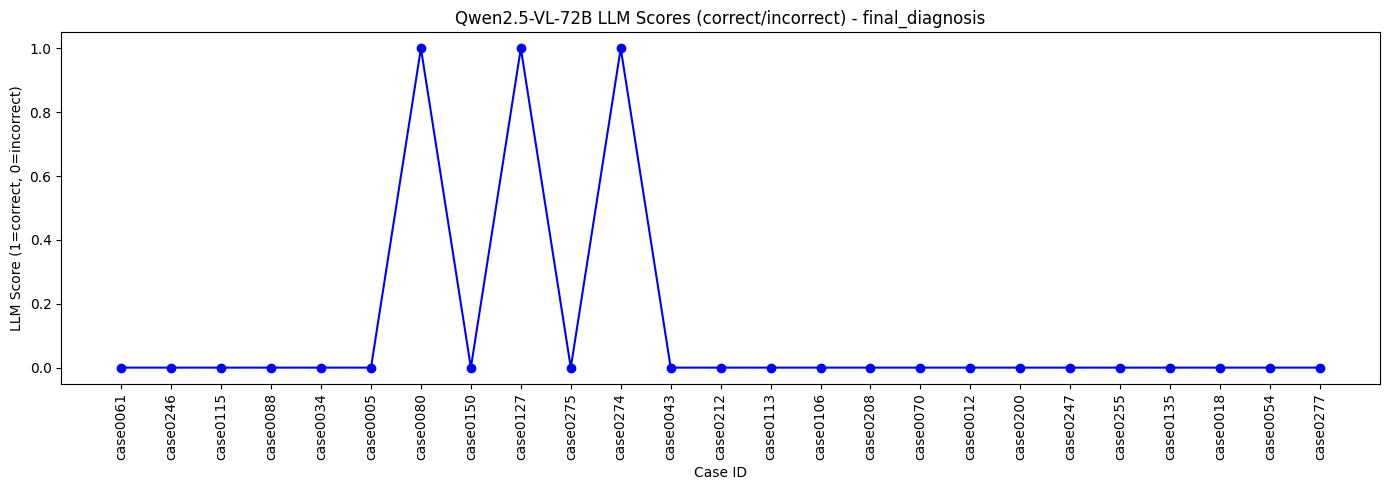

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))

# Map 'correct' to 1, 'incorrect' to 0 for plotting
score_map = {'correct': 1, 'incorrect': 0}
scores = [score_map.get(str(x.get("llm_score", "")).strip().lower(), 0) for x in llm_eval_results]
xaxis = [x.get("case_id", "") for x in llm_eval_results]

plt.plot(xaxis, scores, marker='o', linestyle='-', color='b')
plt.xticks(rotation=90)
plt.xlabel("Case ID")
plt.ylabel("LLM Score (1=correct, 0=incorrect)")
plt.title(f"Qwen2.5-VL-72B LLM Scores (correct/incorrect) - {compare_to}")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, f"llm_scores_{compare_to}.png"))
plt.show()

In [41]:
totoal_corr_pred = sum(1 for x in llm_eval_results if x.get('llm_score', '').strip().lower() == 'correct')
print(f"Number of cases with correct diagnosis: {totoal_corr_pred} out of {len(llm_eval_results)} total cases")
print(f"Percentage of correct diagnoses: {totoal_corr_pred / len(llm_eval_results) * 100:.2f}%")
print(f"Printing cases with correct diagnosis:")
for result in llm_eval_results:
    if result.get("llm_score", "").strip().lower() == "correct":
        print("\n---\n")
        case_id = result.get("case_id")
        #print(f"\nCase ID: {case_id}")
        # Find the corresponding diagnosis result for full info
        case_info = next((x for x in diagnosis_results if x.get("case_id") == case_id), None)
        if case_info:
            for k, v in case_info.items():
                print(f"{k}: {v}")
                

Number of cases with correct diagnosis: 3 out of 25 total cases
Percentage of correct diagnoses: 12.00%
Printing cases with correct diagnosis:

---

case_id: case0080
prediction: Methylmalonic Acidemia
final_diagnosis: Methylmalonic acidaemia (MMA)
prompt: Based on the clinical history: A six-year-old male child presented to the emergency room complaining about weakness, lethargy, abnormal respiration and episodes of vomiting together with dizziness one month before. The parents admitted to developmental delay, eating disorders, seizures, iron-deficiency-anaemia under treatment, and surgical excision of adenoids 2 months ago. Workup revealed elevated ammonia and methylmalonyc acid levels and low vitamin-B12 levels in the blood. and the provided MRI images, provide your diagnosis for the disease. Consider all provided images. Output only the final diagnosis as a short phrase, with no explanation or extra text.
clinical_history: A six-year-old male child presented to the emergency room c